In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
figdir = 'figures/mem_key_value'
!mkdir -p $figdir

In [3]:
duration_seconds = 10

results = []
with open('../benchmarks/mem_key_value/aws_c5n.2xlarge_2020_04_14.jsonl', 'rt') as fp:
    for line in fp:
        spec, counts = json.loads(line)
        spec.update(counts)
        results.append(spec)
results = pd.DataFrame(results)

# filter out results not used in analysis
results = results[results['server_threads'].isin([1, 4, 8, 16, 32])]
results = results[results['client_threads'].isin([1, 4, 8, 16, 32])]
results = results[~((results['client_threads'] == 32) & ~results['server_threads'].isin([8, 16, 32]))]
results = results[results['seconds'] == duration_seconds]
results = results[results['key_length'].isin([2, 16])]

# introduce better labels for workload and keyspace
results['workload'] = results['set_frac'].map({0.1: 'read heavy', 0.5: 'balanced', 0.9: 'write heavy'})
results['keyspace'] = results['key_length'].map({2: 'small', 16: 'large'})

# drop unnecessary columns
assert (results['value_length'] == 64).all()
assert (results['missingKey'] == 0).all()
results = results.drop(['seconds', 'value_length', 'found', 'missingKey', 'set_frac', 'key_length'], axis=1)

# compute total ops
results['ops'] = results['set'] + results['get']


results.head().T

,1,6,9,10,11
server_threads,8,1,8,8,4
client_threads,4,1,8,16,1
map_type,concurrent,hashtable,hashtable,concurrent,hashtable
trial_index,2,2,2,4,4
set,73407,75772,90348,52445,17727
get,73259,8462,90042,474774,160384
workload,balanced,write heavy,balanced,read heavy,read heavy
keyspace,large,large,large,large,large
ops,146666,84234,180390,527219,178111


In [4]:
# normalize operations to be in units of thousands per a second and
# aggregate across trials
x = results.copy()
x['ops'] /= duration_seconds
x['ops'] /= 1000
x = (x.groupby(['workload', 'map_type', 'keyspace', 'server_threads', 'client_threads'])
     ['ops'].describe()
     .drop(['mean', 'std'], axis=1)
     .reset_index()
)
x['count'] = x['count'].astype(int)
norm_agg_ops = x
norm_agg_ops.sample(5)

,workload,map_type,keyspace,server_threads,client_threads,count,min,25%,50%,75%,max
120,read heavy,hashtable,large,4,8,10,37.7122,42.691675,48.36000,49.234400,50.7374
152,write heavy,concurrent,large,1,1,10,8.3770,8.425925,8.82815,9.140625,9.4292
68,balanced,hashtable,small,8,16,10,16.0259,16.430300,16.91815,17.312650,17.5218
188,write heavy,concurrent,small,16,32,10,9.7888,10.015325,10.21580,10.774600,11.1025
79,read heavy,concurrent,large,1,16,10,38.7050,39.801450,40.11160,40.980625,41.1949


In [5]:
incomplete = norm_agg_ops['count'] != 10
if incomplete.sum():
    print('results are incomplete for the following cases')
    display(x[incomplete])
else:
    print('results are complete')

results are complete


server_threads  client_threads  count  \
workload    map_type   keyspace                                          
write heavy hashtable  small                 16              32     10   
            concurrent large                  8              32     10   
                       small                 32              32     10   
            hashtable  large                 32              32     10   
balanced    concurrent small                 16              32     10   
            hashtable  small                 32              32     10   
            concurrent large                 32              32     10   
            hashtable  large                 32              32     10   
read heavy  hashtable  small                 16              32     10   
            concurrent small                 32              32     10   
            hashtable  large                 16              32     10   
            concurrent large                 16              32     10   

                                     min        25%       50%        75%  \
workload    map_type   keyspace                                            
write heavy hashtable  small      9.5935  10.485700  10.70555  10.980625   
            concurrent large     10.2816  10.455575  10.73855  10.948300   
                       small     10.0437  10.464800  10.76190  10.919800   
            hashtable  large     10.3747  10.676325  10.89255  10.941950   
balanced    concurrent small     16.5456  16.783000  17.46325  17.689725   
            hashtable  small     16.8587  17.064525  17.54050  17.641925   
            concurrent large     16.7708  17.234850  17.69690  17.886850   
            hashtable  large     16.9413  17.191750  17.77750  17.884450   
read heavy  hashtable  small     55.2108  55.522975  55.71960  56.140650   
            concurrent small     54.7660  54.977950  56.02750  56.432700   
            hashtable  large     59.2848  61.345100  61.69240  61.788825   
            concurrent large     59.2110  60.495025  61.82335  62.826000   

                                     max  
workload    map_type   keyspace           
write heavy hashtable  small     11.0655  
            concurrent large     11.3549  
                       small     11.0807  
            hashtable  large     11.3067  
balanced    concurrent small     18.2169  
            hashtable  small     18.2764  
            concurrent large     18.7062  
            hashtable  large     17.9226  
read heavy  hashtable  small     57.5675  
            concurrent small     56.5809  
            hashtable  large     61.9462  
            concurrent large     63.1510

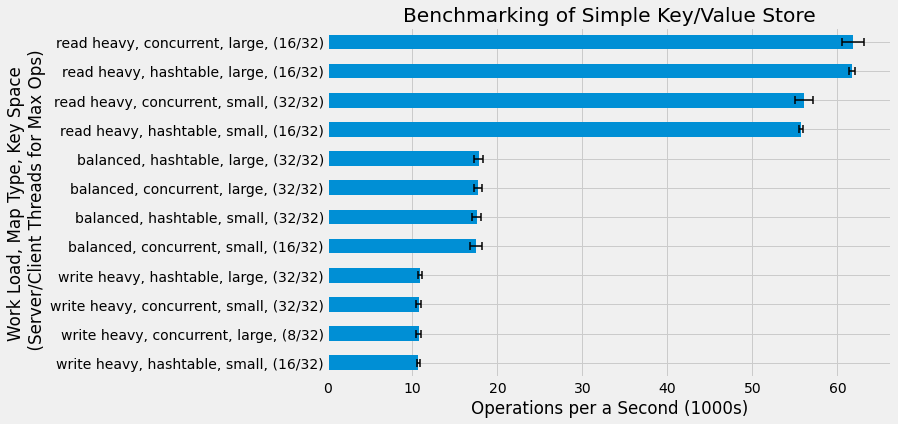

In [6]:
# compute the highest performing thread configuration for each set of parameter
def agg(df):
    agg_ops = df.set_index(['server_threads', 'client_threads'])
    idxmax = agg_ops['50%'].idxmax()
    opsmax = agg_ops.T[idxmax]
    s,c = idxmax
    opsmax['server_threads'] = s
    opsmax['client_threads'] = c
    return opsmax
    return pd.Series({'server_threads':s, 'client_threads':c, 'ops': opsmax})
    return median_ops

x = norm_agg_ops
x = x.groupby(['workload', 'map_type', 'keyspace']).apply(agg).sort_values('50%', ascending=True)
iq = x[['25%', '75%']].copy()
iq['25%'] = x['50%'] - iq['25%']
iq['75%'] -= x['50%']
x.plot.barh(figsize=(9, 6), y='50%', xerr=iq.values.T,
            error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5))
plt.gca().get_legend().remove()
plt.ylabel('Work Load, Map Type, Key Space\n (Server/Client Threads for Max Ops)')
plt.xlabel('Operations per a Second (1000s)')
plt.title('Benchmarking of Simple Key/Value Store')

def label(ix):
    r = x.T[ix]
    workload, map_type, keyspace = ix
    return f'{workload}, {map_type}, {keyspace}, ({int(r["server_threads"])}/{int(r["client_threads"])})'

plt.gca().set_yticklabels(map(label, x.index))
plt.savefig(figdir + '/benchmarking.png', bbox_inches='tight')
display(x[['server_threads', 'client_threads', 'count', 'min', '25%', '50%', '75%', 'max']])

In [7]:
def analyze_thread_performance(ax, workload, map_type, keyspace):
    x = norm_agg_ops
    x = x[(x['workload'] == workload) & (x['map_type'] == map_type) & (x['keyspace'] == keyspace)]
    x = x.set_index(['server_threads', 'client_threads'])
    x = x.sort_values('50%')
    
    top_index = list(x.index[-10::])
    if (1,1) not in top_index:
        del top_index[0]
        top_index.insert(0, (1,1))
    x = x[x.index.isin(top_index)]
    
    iq = x[['25%', '75%']].copy()
    iq['25%'] = x['50%'] - iq['25%']
    iq['75%'] -= x['50%']
    x.plot.barh(ax=ax, y='50%', xerr=iq.values.T,
                error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5))
    plt.ylabel('Server Threads, Client Threads')
    plt.xlabel('Operations per a Second (1000s)')
    ax.get_legend().remove()
    ax.set_yticklabels(map(lambda i: ', '.join(map(str, i)), x.index))
    
    m = x['50%']
    rel_diff = (m.max() - m.min()) / m.min()
    ax.set_title(f'{workload} workload (relative difference of {rel_diff*100:.1f}%)')

    return x
    
def analyze_workload_thread_performance(map_type, keyspace, x_max=65):
    fig = plt.figure(figsize=(9,15))
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'Threading impact for {map_type} map and {keyspace} key space', y=0.93, size=24)
    for i,workload in enumerate(['read heavy', 'balanced', 'write heavy']):
        ax = plt.subplot(3, 1, i+1)
        ax.set_xlim(0, x_max)
        analyze_thread_performance(ax, workload, map_type, keyspace)

    plt.savefig(figdir + f'/threading_{map_type}_{keyspace}.png', bbox_inches='tight')


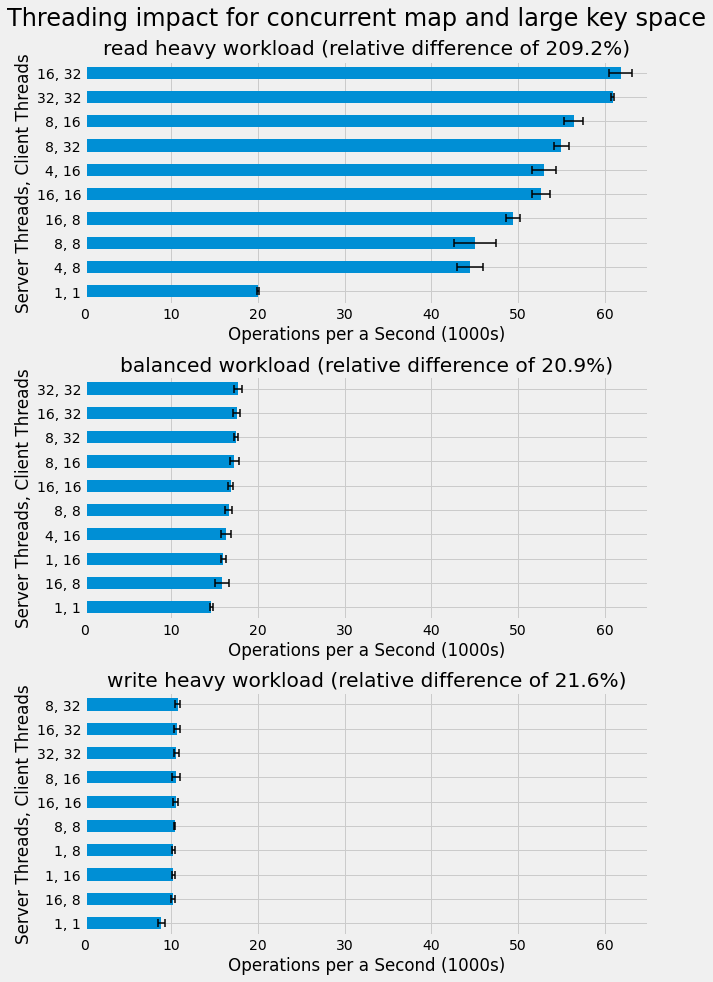

In [8]:
analyze_workload_thread_performance('concurrent', 'large')

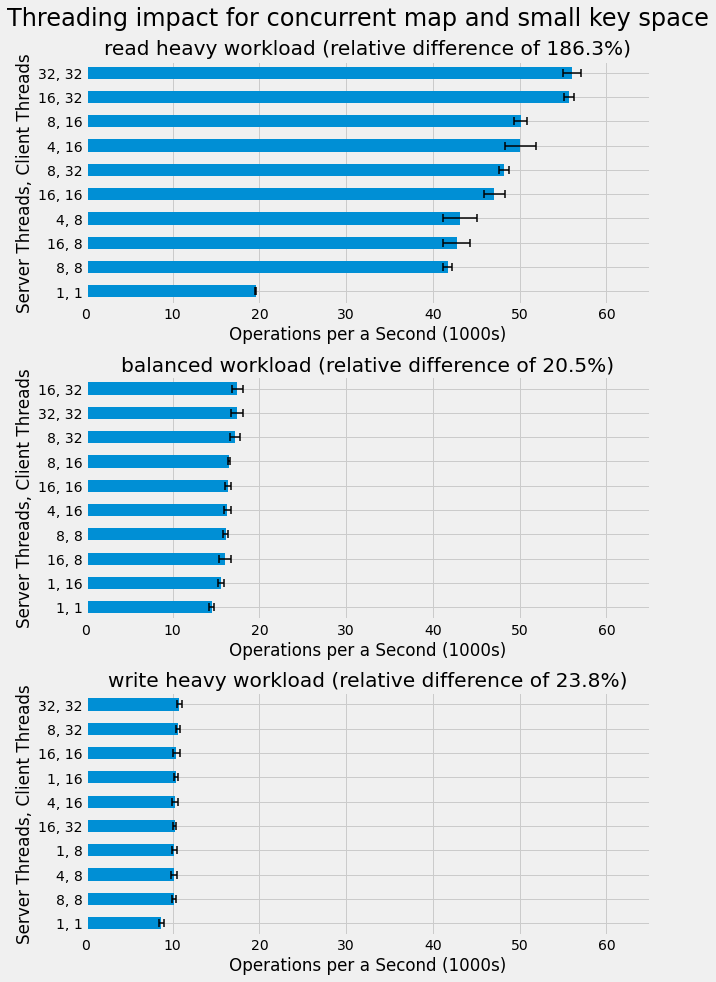

In [9]:
analyze_workload_thread_performance('concurrent', 'small')

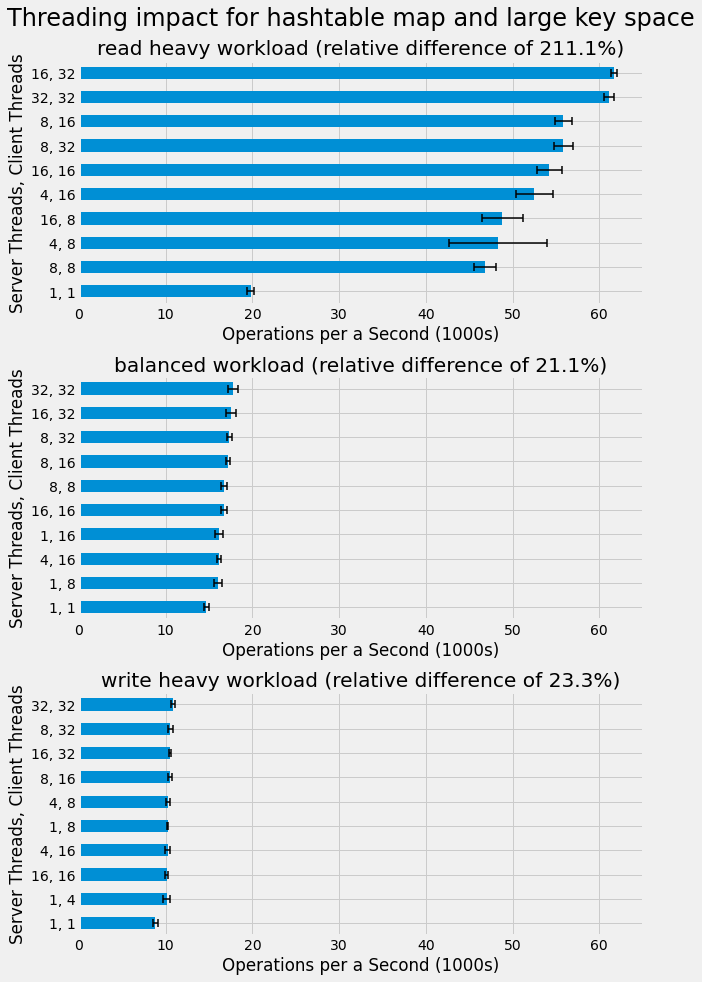

In [10]:
analyze_workload_thread_performance('hashtable', 'large')

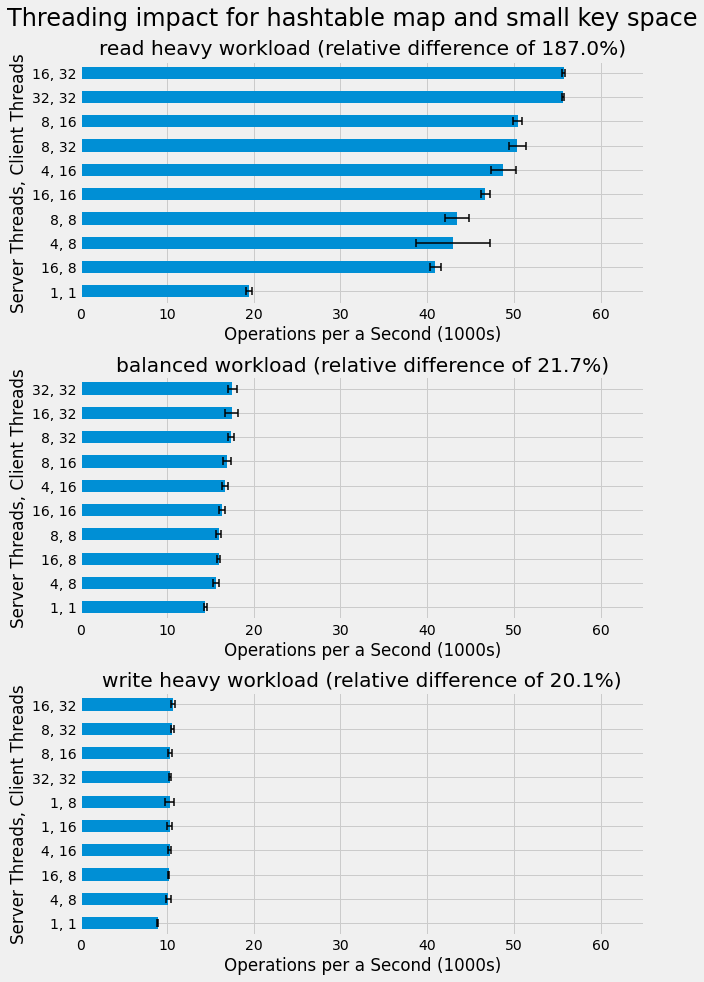

In [11]:
analyze_workload_thread_performance('hashtable', 'small')